In [ ]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import re
import os
import time
import datetime as dt
import importlib
import warnings
import cloudpickle
from functools import reduce
import joblib as jl

import packages.tools as tools
import packages.models as models

import statsmodels as sms
import statsmodels.tsa as tsa
import statsmodels.api as sm
import statsmodels.formula.api as smf

import pmdarima as pmd

from sklearn import metrics

warnings.filterwarnings("ignore")

## Models:
We will use the following ARIMA models (primarily for benchmarking):
1. Univariate AR
2. Multivariate AR on $X_{\text{price},t}$ (i.e. univariate AR with exogenous predictors)
3. SARIMA
4. Multivariate SARIMA

If time permits, and if we encounter other ARIMA models of interest, then we will design implementations for these as well.

### Read in (pre-processed) dataset

In [ ]:
importlib.reload(tools)

In [ ]:
path_dam_prices = ["Datasets/DAMPrices.csv", "Datasets/DAMPrices2.csv"]

# Read in dataset
dam_prices = tools.read_price_data(path_dam_prices)

The two tables below show the original and 'preprocessed' price data, respectively.

In [ ]:
pd.read_csv(path_dam_prices[0]).head(3)

In [ ]:
dam_prices.head(3)

### 0. Define function for transforming dataset

In [ ]:
test = dam_prices.head()

In [ ]:
def stationarize(series):
    stat_series = series.diff()
    stat_series.drop(stat_series.index[0], inplace=True)
    return(stat_series)
    
def destationarize(series, y_0):
    new_series = series.cumsum()
    new_index = pd.DatetimeIndex([series.index[0] - dt.timedelta(hours=1)])
    new_series = pd.concat([pd.DataFrame(columns=series.columns, index=new_index, data=np.zeros(len(series.columns))), new_series])
    new_series += y_0
    new_series.index.name = series.index.name
    return(new_series)

### 1. Univariate AR

In [ ]:
"""
Parameters:
    data: pd.DataFrame
    target: datetime
    p: int
        AR model parameter
    trend: str
    forecast_steps: int
"""

def AR(data, lags, exog=None, test_exog=None, trend='ct', forecast_steps=24, jl_n_jobs=-1, jl_backend="threading", ic='aic'):
    # Fit AR models with different lag values
    if (exog is None) and (test_exog is None):
        ar_model_selection = jl.Parallel(n_jobs=jl_n_jobs, backend=jl_backend) \
            (jl.delayed(tsa.ar_model.AutoReg(endog=data.values,lags=lag,trend=trend).fit)() for lag in lags)
    else:
        ar_model_selection = jl.Parallel(n_jobs=jl_n_jobs, backend=jl_backend) \
            (jl.delayed(tsa.ar_model.AutoReg(endog=data.values,exog=exog.values,lags=lag,trend=trend).fit)() for lag in lags)
    
    # Pick best model based on either BIC or AIC
    ar_ics = [ar_model.aic for ar_model in ar_model_selection] if ic=='aic' else [ar_model.bic for ar_model in ar_model_selection]
    best_model = ar_model_selection[ar_ics.index(min(ar_ics))]
    
    # Make forecasts
    if (exog is None) and (test_exog is None):
        forecast = best_model.predict(start=data.shape[0], end=data.shape[0]+forecast_steps-1)
    else:
        forecast = best_model.predict(start=data.shape[0], end=data.shape[0]+forecast_steps-1, exog_oos=test_exog)
    
    # Create and prepare forecasts dataframe
    forecast_df = pd.DataFrame(dict(EURPrices=forecast), columns=["EURPrices"])
    forecast_df.index = pd.date_range(data.index[-1]+dt.timedelta(hours=1), periods=forecast_steps, freq="H")
    forecast_df.index.name = "DeliveryPeriod"
    
    return(best_model, forecast_df)

In [ ]:
train_prices = dam_prices[:-24]
test_prices = dam_prices[-24:]

In [ ]:
start = time.time()
lags = list(range(1,700, 25)) + [700]
mod, forecast = AR(data=train_prices, lags=lags, ic='bic')
print(f"{time.time() - start} seconds")
print(forecast.head())

In [ ]:
test = pd.DataFrame(data=dict(forecast=forecast["EURPrices"], original=test_prices["EURPrices"]))
test.plot()

In [ ]:
metrics.mean_squared_error(test["forecast"], test["original"], squared=False)

### Comparing ARIMA(p,1,0) -v- AR(p) 

In [ ]:
st_prices = stationarize(dam_prices)
train_st_prices = st_prices[:-24]
test_st_prices = st_prices[-24:]

In [ ]:
start = time.time()
st_mod, st_forecast = AR(data=train_st_prices, trend="n", lags=lags, ic='bic')
print(f"{time.time() - start} seconds")
print(st_forecast.head())

In [ ]:
st_test = pd.DataFrame(data=dict(forecast=st_forecast["EURPrices"], original=test_st_prices["EURPrices"]))
st_test.plot()

In [ ]:
interm = train_st_prices.append(st_forecast)

In [ ]:
norm_forecast = destationarize(interm, train_prices.values[0])[-24:]

In [ ]:
norm_test = pd.DataFrame(data=dict(forecast=norm_forecast["EURPrices"], original=test_prices["EURPrices"]))
norm_test.plot()

In [ ]:
metrics.mean_squared_error(st_test["forecast"], st_test["original"], squared=False)

In [ ]:
metrics.mean_squared_error(norm_test["forecast"], norm_test["original"], squared=False)

In [ ]:
ax=forecast.plot()
norm_forecast.plot(ax=ax)

### 2. Multivariate AR on $X_{price,t}$

### Read in Exogenous data

In [ ]:
# Read in the datasets
price_path = ["Datasets/DAMPrices.csv", "Datasets/DAMPrices2.csv"]
prices = tools.read_price_data(price_path)

bm_price_paths = ["Datasets/BMInfo1.csv", "Datasets/BMInfo2.csv", "Datasets/BMInfo3.csv"]
bm_prices = tools.read_bm_price_data(bm_price_paths)

wind_path = ["Datasets/WindForecast.csv", "Datasets/WindForecast2.csv"]
wind_forecast = tools.read_forecast_data(wind_path)
wind_forecast.columns = ["Wind"]

demand_path = ["Datasets/DemandForecast.csv", "Datasets/DemandForecast2.csv"]
demand_forecast = tools.read_forecast_data(demand_path)
demand_forecast.columns = ["Demand"]

availabilities_path = ["Datasets/AvailabilityProxy.csv", "Datasets/AvailabilityProxy2.csv"]
availabilities = tools.read_availabilities_data(availabilities_path)

In [ ]:
# Combine the datasets
planned_list = [wind_forecast, demand_forecast]
start_dates = list(map(lambda var: var.index[0], [prices, bm_prices, availabilities]+planned_list))
latest_start_date = max(start_dates)
target_end_date = prices.index[-1]

# Check for variables that do not have enough data for forecast date (last day of prices)
for var in planned_list+[prices,availabilities]:
    if var.index[-1] < target_end_date:
        print(f"Must not include {var.columns}")
        
planned_variables = reduce(lambda df1, df2: df1.join(df2), planned_list).loc[latest_start_date:target_end_date]

# Split into training and test set
last_day_of_data = dt.datetime.combine(prices.index.date[-1], dt.datetime.min.time())
test_data_index = pd.date_range(start=last_day_of_data, end=last_day_of_data+dt.timedelta(hours=23), freq='h')

# Test data
test_prices = prices.loc[test_data_index]

# Training data + predictors for forecast
train_prices = prices.loc[:last_day_of_data-dt.timedelta(hours=1)]
train_bm_prices = bm_prices.loc[:last_day_of_data-dt.timedelta(hours=1)]
train_planned_variables = planned_variables.loc[:test_data_index[-1]]

# Build predictor dataframes
price_lags = [24,48,72,96,120,144,168]
bm_price_lags = [24,48,72,96,168]
planned_lags = [0,24,48,72,96,168]

predictors = pd.DataFrame(index=train_planned_variables.index)

# Build predictors from EURPrices
for lag in price_lags:
    predictor_name = f"{train_prices.columns[0]}-{lag}"
    predictors.insert(predictors.shape[1], predictor_name, train_prices)
    predictors[predictor_name] = predictors[predictor_name].shift(lag)
    
# Build predictors from BMImbalancePrice
for lag in bm_price_lags:
    predictor_name = f"{train_bm_prices.columns[0]}-{lag}"
    predictors.insert(predictors.shape[1], predictor_name, train_bm_prices)
    predictors[predictor_name] = predictors[predictor_name].shift(lag)
    
# Build predictors from wind and demand forecasts
for column in train_planned_variables.columns:
    for lag in planned_lags:
        predictor_name = f"{column}-{lag}"
        predictors.insert(predictors.shape[1], predictor_name, train_planned_variables[[column]])
        predictors[predictor_name] = predictors[predictor_name].shift(lag)

# Split predictors and target into training and test sets
train_predictors = predictors.drop(test_data_index)
test_predictors = predictors.loc[test_data_index]
train_target = train_prices["EURPrices"]
test_target = test_prices["EURPrices"]

# Remove rows in training set with NAs
notna_train_predictors_loc = train_predictors.notna().all(axis=1)
train_predictors = train_predictors.loc[notna_train_predictors_loc]
train_target = train_target.loc[notna_train_predictors_loc]

### Now to build the model and make forecasts

In [ ]:
start = time.time()
modx, forecastx = AR(data=train_target, lags=lags, exog=train_predictors, test_exog=test_predictors, trend="n", ic='bic')
print(f"{time.time() - start} seconds")
print(forecastx.head())

In [ ]:
testx = pd.DataFrame(data=dict(forecast=forecastx["EURPrices"], original=test_target))
testx.plot()

In [ ]:
metrics.mean_squared_error(testx["forecast"], testx["original"], squared=False)

### Comparing AR-X  -v-  AR-X + stationarizing

In [ ]:
st_pricesx = stationarize(prices)
train_st_pricesx = st_pricesx.loc[train_predictors.index]
test_st_pricesx = st_pricesx.loc[test_predictors.index]

In [ ]:
start = time.time()
st_modx, st_forecastx = AR(data=train_st_pricesx, exog=train_predictors,
                           test_exog=test_predictors, trend="n", lags=lags, ic='bic')
print(f"{time.time() - start} seconds")
print(st_forecastx.head())

In [ ]:
st_testx = pd.DataFrame(data=dict(forecast=st_forecastx["EURPrices"], original=test_st_pricesx["EURPrices"]))
st_testx.plot()

In [ ]:
intermx = train_st_pricesx.append(st_forecastx)

In [ ]:
norm_forecastx = destationarize(intermx, prices.loc[train_st_pricesx.index[0]-dt.timedelta(hours=1)].values[0])[-24:]

In [ ]:
norm_testx = pd.DataFrame(data=dict(forecast=norm_forecastx["EURPrices"], original=test_target))
norm_testx.plot()

In [ ]:
metrics.mean_squared_error(st_testx["forecast"], st_testx["original"], squared=False)

In [ ]:
metrics.mean_squared_error(norm_testx["forecast"], norm_testx["original"], squared=False)

In [ ]:
ax=forecastx.plot()
norm_forecastx.plot(ax=ax)

### 3. SARIMA

### Initial analysis

In [5]:
prices = dam_prices.copy()

NameError: name 'dam_prices' is not defined

In [8]:
def evaluate_stationarity(data, rolling_mean_window=5, rolling_std_window=5, acf_lags=50, pacf_lags=50, acf_vlines=[24,48],
                          pacf_vlines=[24,48], confidence=0.95):
    # Run ADF test for stationarity
    rolling_mean = data.dropna().rolling(rolling_mean_window).mean()
    rolling_std = data.dropna().rolling(rolling_std_window).std()
    ax = data.plot(figsize=(10,5))
    rolling_mean.plot(color='red', ax=ax)
    rolling_std.plot(color='blue', ax=ax)
    ax.legend(["Original Data", "Mean", "Standard Deviation"], loc='best')
    
    test = sm.tsa.adfuller(data.dropna())
    results = pd.Series(test[0:4], index=["Test statistic", "p-value", "No. of lags used", "No. of observations used"])
    for key, val in test[4].items():
        results[f"{key} critical value"] = val
    results["Best IC value"] = test[5]
    print("Augmented Dicky-Fuller Test Results:")    
    print(results)
    if test[1] > 1-confidence:
        print("Conclusion: Time series data is not stationary")
    else:
        print("Conclusion: Time series data is stationary")
    
    fig, ax1 = plt.subplots(1,2,figsize=(15,5))
    
    # Plot ACF
    sm.graphics.tsa.plot_acf(data.dropna(), ax=ax1[0], lags=acf_lags)
    if acf_vlines is not None:
        for lag in acf_vlines:
            ax1[0].axvline(lag, linestyle='--', linewidth=0.8, color='red')
    
    # Plot PACF
    sm.graphics.tsa.plot_pacf(data.dropna(), ax=ax1[1], lags=pacf_lags)
    if pacf_vlines is not None:
        for lag in pacf_vlines:
            ax1[1].axvline(lag, linestyle='--', linewidth=0.8, color='red')

Augmented Dicky-Fuller Test Results:
Test statistic             -7.744955e+00
p-value                     1.037908e-11
No. of lags used            4.200000e+01
No. of observations used    1.450100e+04
1% critical value          -3.430801e+00
5% critical value          -2.861739e+00
10% critical value         -2.566876e+00
Best IC value               1.022019e+05
dtype: float64
Conclusion: Time series data is stationary


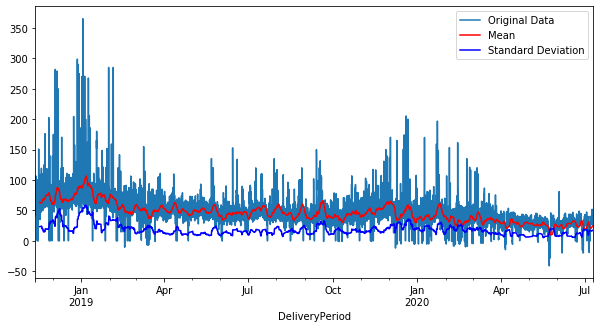

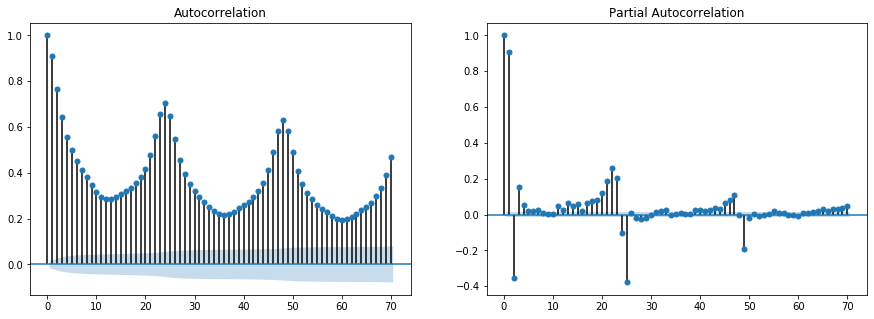

In [9]:
evaluate_stationarity(prices["EURPrices"], rolling_mean_window=120, rolling_std_window=120,
                      acf_lags=70, pacf_lags=70, acf_vlines=None, pacf_vlines=None)

In [10]:
prices["EURPrices_24h"] = prices["EURPrices"].diff(periods=24)

Augmented Dicky-Fuller Test Results:
Test statistic                 -22.208512
p-value                          0.000000
No. of lags used                42.000000
No. of observations used     14477.000000
1% critical value               -3.430802
5% critical value               -2.861740
10% critical value              -2.566876
Best IC value               103275.912203
dtype: float64
Conclusion: Time series data is stationary


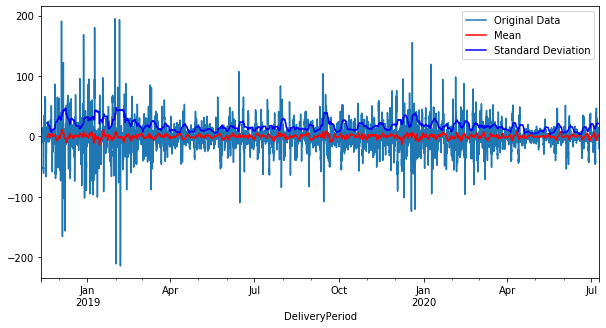

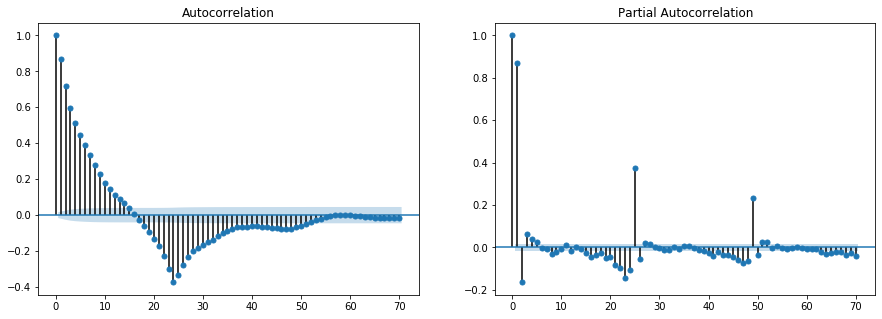

In [11]:
evaluate_stationarity(prices["EURPrices_24h"], rolling_mean_window=120, rolling_std_window=120,
                      acf_vlines=None, pacf_vlines=None, acf_lags=70, pacf_lags=70)

As expected, mean seems relatively constant (so no linear trend); variance of course is not, due to the price spikes. Although the ADF test shows stationarity, our job is far from over...

As expected from the generally known behaviour of electricity prices, the ACF shows weekly seasonality (peaks at lags 24 and 48, indicated by the red dashed vertical lines).

So, we will difference the data by 24 lags/hours.

In [12]:
prices["EURPrices_24h_1h"] = prices["EURPrices_24h"].diff()

Augmented Dicky-Fuller Test Results:
Test statistic                 -32.168110
p-value                          0.000000
No. of lags used                37.000000
No. of observations used     14481.000000
1% critical value               -3.430802
5% critical value               -2.861740
10% critical value              -2.566876
Best IC value               103748.914794
dtype: float64
Conclusion: Time series data is stationary


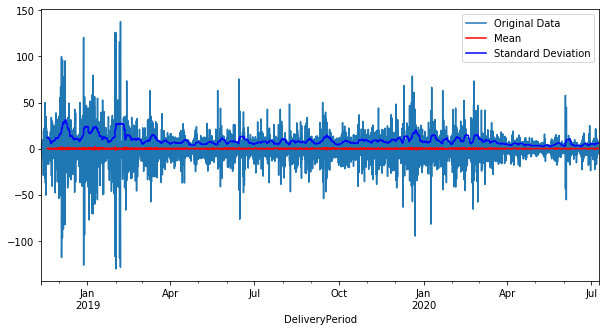

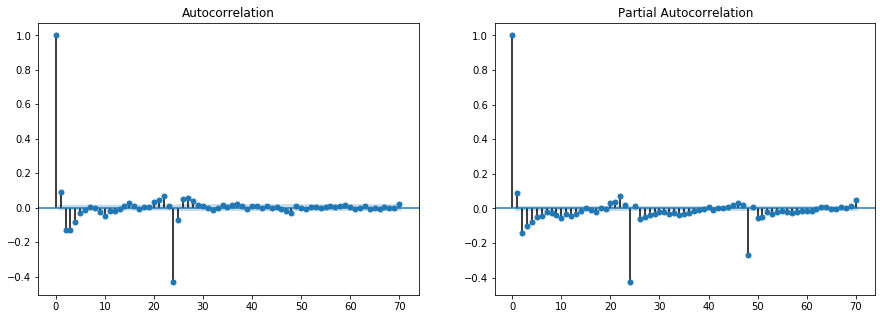

In [13]:
%matplotlib inline
evaluate_stationarity(prices["EURPrices_24h_1h"], rolling_mean_window=120, rolling_std_window=120,
                      acf_vlines=None, pacf_vlines=None, acf_lags=70, pacf_lags=70)

Obviously (I think), this indicates that there are several dependencies that occur over days (not so much hours). After one hour differencing, most of the remaining correlation then seemed to come from a few hours before and from whole days before.

Therefore, I expect that when we train our SARIMA model, the strongest parameters affecting $t$ would be parameters $t-1, t-2, t-3, t-4$ and no further, as well as $(t-24n), n \in \mathbb{N}$ and from the hours near $(t-24n)$, e.g. something like $\text{SARIMA}(4,1,4)\times(0,1,1)_{24}$

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import re
import os
import time
import datetime as dt
import importlib
import warnings
import cloudpickle
from functools import reduce
import joblib as jl

import packages.tools as tools
import packages.models as models

import statsmodels as sms
import statsmodels.tsa as tsa
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn import metrics

warnings.filterwarnings("ignore")

In [14]:
# Read in the datasets
price_path = ["Datasets/DAMPrices.csv", "Datasets/DAMPrices2.csv"]
prices = tools.read_price_data(price_path)

bm_price_paths = ["Datasets/BMInfo1.csv", "Datasets/BMInfo2.csv", "Datasets/BMInfo3.csv"]
bm_prices = tools.read_bm_price_data(bm_price_paths)

wind_path = ["Datasets/WindForecast.csv", "Datasets/WindForecast2.csv"]
wind_forecast = tools.read_forecast_data(wind_path)
wind_forecast.columns = ["Wind"]

demand_path = ["Datasets/DemandForecast.csv", "Datasets/DemandForecast2.csv"]
demand_forecast = tools.read_forecast_data(demand_path)
demand_forecast.columns = ["Demand"]

availabilities_path = ["Datasets/AvailabilityProxy.csv", "Datasets/AvailabilityProxy2.csv"]
availabilities = tools.read_availabilities_data(availabilities_path)

In [15]:
# Combine the datasets
planned_list = [wind_forecast, demand_forecast]
start_dates = list(map(lambda var: var.index[0], [prices, bm_prices, availabilities]+planned_list))
latest_start_date = max(start_dates)
target_end_date = prices.index[-1]

# Check for variables that do not have enough data for forecast date (last day of prices)
for var in planned_list+[prices,availabilities]:
    if var.index[-1] < target_end_date:
        print(f"Must not include {var.columns}")
        
planned_variables = reduce(lambda df1, df2: df1.join(df2), planned_list).loc[latest_start_date:target_end_date]

# Split into training and test set
last_day_of_data = dt.datetime.combine(prices.index.date[-1], dt.datetime.min.time())
test_data_index = pd.date_range(start=last_day_of_data, end=last_day_of_data+dt.timedelta(hours=23), freq='h')

# Test data
test_prices = prices.loc[test_data_index]

# Training data + predictors for forecast
train_prices = prices.loc[:last_day_of_data-dt.timedelta(hours=1)]
train_bm_prices = bm_prices.loc[:last_day_of_data-dt.timedelta(hours=1)]
train_planned_variables = planned_variables.loc[:test_data_index[-1]]

# Build predictor dataframes
bm_price_lags = [24,48,72,96,168]
planned_lags = [0,24,48,72,96,168]

predictors = pd.DataFrame(index=train_planned_variables.index)

# Build predictors from BMImbalancePrice
for lag in bm_price_lags:
    predictor_name = f"{train_bm_prices.columns[0]}-{lag}"
    predictors.insert(predictors.shape[1], predictor_name, train_bm_prices)
    predictors[predictor_name] = predictors[predictor_name].shift(lag)
    
# Build predictors from wind and demand forecasts
for column in train_planned_variables.columns:
    for lag in planned_lags:
        predictor_name = f"{column}-{lag}"
        predictors.insert(predictors.shape[1], predictor_name, train_planned_variables[[column]])
        predictors[predictor_name] = predictors[predictor_name].shift(lag)

# Split predictors and target into training and test sets
train_predictors = predictors.drop(test_data_index)
test_predictors = predictors.loc[test_data_index]
train_target = train_prices["EURPrices"]
test_target = test_prices["EURPrices"]

# Remove rows in training set with NAs
notna_train_predictors_loc = train_predictors.notna().all(axis=1)
train_predictors = train_predictors.loc[notna_train_predictors_loc]
train_target = train_target.loc[notna_train_predictors_loc]

Must not include Index(['WIND', 'MULTI_FUEL', 'GAS', 'HYDRO', 'PEAT', 'COAL', 'PUMP_STORAGE',
       'BIOMASS', 'OIL', 'DISTILLATE', 'SOLAR', 'NONE'],
      dtype='object')


In [16]:
"""
Parameters:
    data: pd.DataFrame
    target: datetime
    p: int
        AR model parameter
    trend: str
    forecast_steps: int
"""

def SARIMA(data, order, sorder, exog=None, test_exog=None, trend="n", method="bfgs", maxiter=50, disp=True, forecast_steps=24, jl_n_jobs=-1, jl_backend="threading"):
    # Fit SARIMA model and make forecasts
    if (exog is None) and (test_exog is None):
        model = tsa.statespace.sarimax.SARIMAX(endog=data.values, order=order, seasonal_order=sorder,trend=trend).fit(method=method, maxiter=maxiter, disp=disp)
        forecast = model.predict(start=data.shape[0], end=data.shape[0]+forecast_steps-1)
    else:
        model = tsa.statespace.sarimax.SARIMAX(endog=data.values, exog=exog, order=order, seasonal_order=sorder,trend=trend).fit(method=method, maxiter=maxiter, disp=disp)
        forecast = model.predict(start=data.shape[0], end=data.shape[0]+forecast_steps-1, exog=test_exog)
    
    # Create and prepare forecasts dataframe
    forecast_df = pd.DataFrame(dict(EURPrices=forecast), columns=["EURPrices"])
    forecast_df.index = pd.date_range(data.index[-1]+dt.timedelta(hours=1), periods=forecast_steps, freq="H")
    forecast_df.index.name = "DeliveryPeriod"
    
    return(model, forecast_df)

In [185]:
order = (4,1,4)
sorder = (0,1,1,24)
short_train_target = train_target.iloc[-(24*6):]
mod, forecast_df = SARIMA(short_train_target, order, sorder)

         Current function value: 2.426749
         Iterations: 17
         Function evaluations: 90
         Gradient evaluations: 78


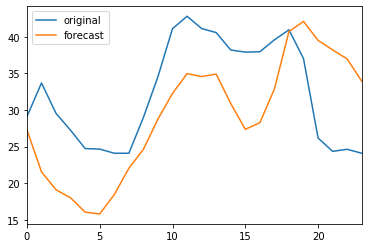

In [18]:
test_df = pd.DataFrame(dict(original=test_target.values, forecast=test_forecast_df.values.flatten()))
test_df.plot()

In [187]:
print("RMSE:", metrics.mean_squared_error(test_df["original"], test_df["forecast"], squared=False),
      "\nMAE:", metrics.mean_absolute_error(test_df["original"], test_df["forecast"]))

RMSE: 8.263755077204872 
MAE: 7.4153168536672736


In [188]:
mod.params

array([ 2.97361731e-01,  2.94306344e-01, -3.30157949e-01,  2.31223650e-02,
       -1.63381168e-04, -2.44350244e-01, -2.69334972e-02,  6.48049460e-02,
       -9.23854833e-01,  1.55772977e+01])

In [189]:
order = (4,1,4)
sorder = (0,1,1,24)
short_train_predictors = train_predictors.loc[short_train_target.index]
mod, forecast_df = SARIMA(short_train_target, order, sorder, exog=short_train_predictors, test_exog=test_predictors, maxiter=50)

         Current function value: 2.549822
         Iterations: 19
         Function evaluations: 68
         Gradient evaluations: 56


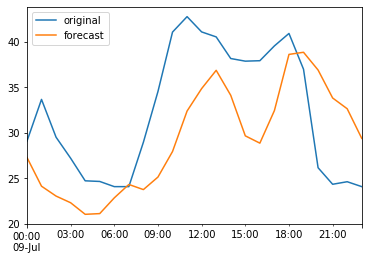

In [22]:
test_df = pd.DataFrame(dict(original=test_target.values, forecast=test_forecast_df.values.flatten()), index=test_target.index)
test_df.plot()

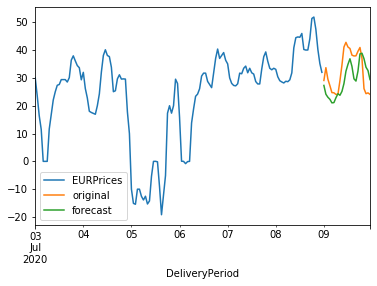

In [24]:
ax = pd.DataFrame(short_train_target).plot()
test_df.plot(ax=ax)

In [191]:
print("RMSE:", metrics.mean_squared_error(test_df["original"], test_df["forecast"], squared=False),
      "\nMAE:", metrics.mean_absolute_error(test_df["original"], test_df["forecast"]))

RMSE: 5.5076678778843275 
MAE: 4.733107120966431


In [192]:
mod.params

ImbalancePrice-24     -0.013483
ImbalancePrice-48     -0.004130
ImbalancePrice-72     -0.011811
ImbalancePrice-96     -0.014254
ImbalancePrice-168    -0.011301
Wind-0                -0.009286
Wind-24               -0.003619
Wind-48               -0.001802
Wind-72                0.000145
Wind-96               -0.000467
Wind-168              -0.003104
Demand-0               0.002749
Demand-24              0.006518
Demand-48             -0.000098
Demand-72              0.003742
Demand-96              0.001953
Demand-168             0.000444
ar.L1                 -0.706943
ar.L2                  0.192843
ar.L3                 -0.294548
ar.L4                 -0.697989
ma.L1                  0.221882
ma.L2                 -0.081627
ma.L3                  0.183602
ma.L4                  0.100241
ma.S.L24              -0.336778
sigma2                21.241405
dtype: float64

<IPython.core.display.Javascript object>


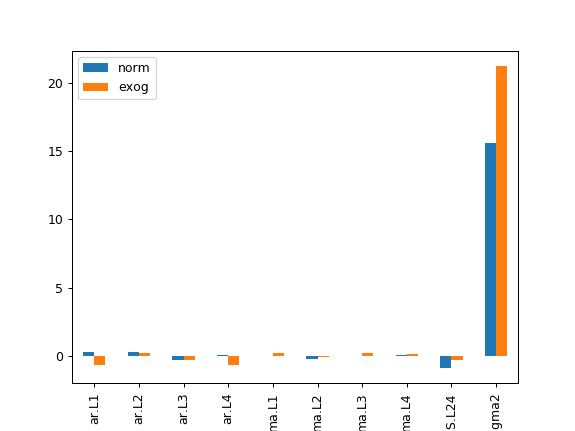

In [216]:
pd.DataFrame(data=dict(norm=np.array([ 2.97361731e-01,  2.94306344e-01, -3.30157949e-01,  2.31223650e-02,
       -1.63381168e-04, -2.44350244e-01, -2.69334972e-02,  6.48049460e-02,
       -9.23854833e-01,  1.55772977e+01]),exog=mod.params.values[-10:]), index=mod.param_names[-10:]).plot.bar()

<IPython.core.display.Javascript object>


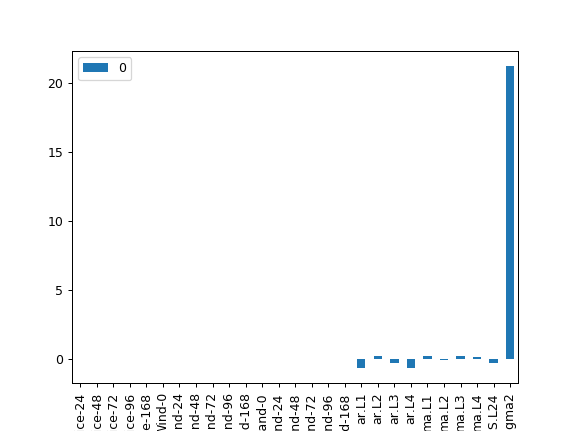

In [217]:
mod.params.to_frame().plot.bar()